# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

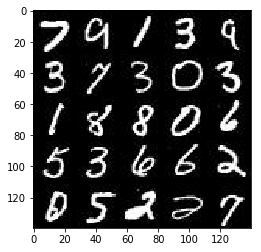

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

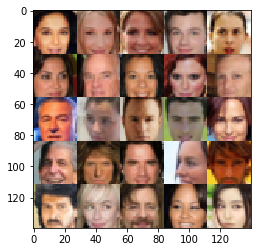

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #print('d image shape', images.shape)
        #28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        #14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        #7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        #print('d relu3', relu3.shape)
        #4x4x256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not(is_train)):
        # fully connected layer
        #print('g input z', z.shape)
        x1 = tf.layers.dense(z, 7*7*512)
        
        # reshape for convolution
        x2 = tf.reshape(x1, (-1, 7, 7, 512))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        #print('g relu2 shape', relu2.shape)
        
        # 7x7x512
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # 14x14x256
        x4 = tf.layers.conv2d_transpose(relu3, 128, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha*bn4, bn4)
        #print('g relu4 shape', relu4.shape)
        
        # 24x24x128
        #print('out_channel_dim', out_channel_dim)
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='same')
        #print('g logits', logits.shape)
        #logits = tf.layers.dense(logits, 28*28*out_channel_dim)
        #logits = tf.reshape(logits, (-1, 28, 28, out_channel_dim))
        
        # 28x28xout_channel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    n = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                n += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate
                                                    })
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate
                                                    })
                if n % 5 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Steps {}".format(n),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if n % 20 == 0:
                    show_generator_output(sess, 4, input_z, len(data_image_mode), data_image_mode)
        print('Finished Training. The result: ')
        show_generator_output(sess, 4, input_z, len(data_image_mode), data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Steps 5 Discriminator Loss: 0.0933 Generator Loss: 2.9338
Steps 10 Discriminator Loss: 0.0158 Generator Loss: 6.7376
Steps 15 Discriminator Loss: 0.0265 Generator Loss: 5.8472
Steps 20 Discriminator Loss: 0.1157 Generator Loss: 7.6173


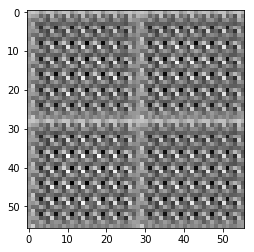

Steps 25 Discriminator Loss: 0.4525 Generator Loss: 1.6424
Steps 30 Discriminator Loss: 0.0413 Generator Loss: 7.7521
Steps 35 Discriminator Loss: 0.0105 Generator Loss: 8.1512
Steps 40 Discriminator Loss: 0.0072 Generator Loss: 8.6159


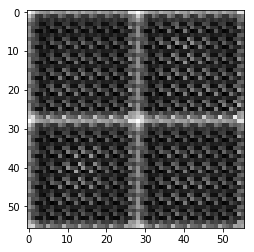

Steps 45 Discriminator Loss: 0.0147 Generator Loss: 4.9677
Steps 50 Discriminator Loss: 0.0050 Generator Loss: 6.1077
Steps 55 Discriminator Loss: 0.0103 Generator Loss: 4.9929
Steps 60 Discriminator Loss: 0.0107 Generator Loss: 5.1699


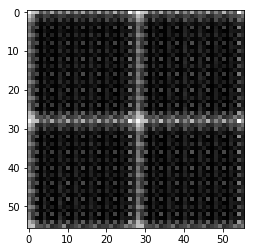

Steps 65 Discriminator Loss: 1.4464 Generator Loss: 0.3197
Steps 70 Discriminator Loss: 0.0676 Generator Loss: 17.8499
Steps 75 Discriminator Loss: 0.0898 Generator Loss: 2.7793
Steps 80 Discriminator Loss: 0.0066 Generator Loss: 11.8406


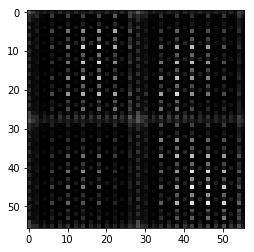

Steps 85 Discriminator Loss: 0.0025 Generator Loss: 10.4244
Steps 90 Discriminator Loss: 0.0110 Generator Loss: 7.9884
Steps 95 Discriminator Loss: 0.0020 Generator Loss: 10.1266
Steps 100 Discriminator Loss: 0.0224 Generator Loss: 6.7412


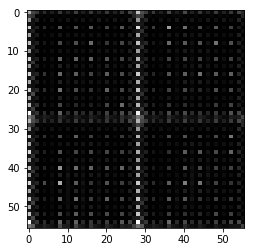

Steps 105 Discriminator Loss: 1.0623 Generator Loss: 1.0165
Steps 110 Discriminator Loss: 1.8564 Generator Loss: 1.7071
Steps 115 Discriminator Loss: 0.3764 Generator Loss: 3.2074
Steps 120 Discriminator Loss: 0.8600 Generator Loss: 3.5330


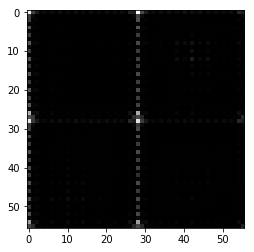

Steps 125 Discriminator Loss: 0.0835 Generator Loss: 3.3926
Steps 130 Discriminator Loss: 0.0395 Generator Loss: 4.6734
Steps 135 Discriminator Loss: 0.0206 Generator Loss: 5.3446
Steps 140 Discriminator Loss: 0.3349 Generator Loss: 1.6088


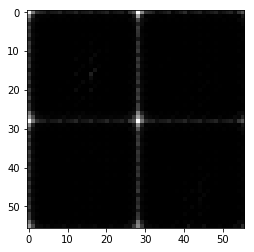

Steps 145 Discriminator Loss: 0.1725 Generator Loss: 9.1614
Steps 150 Discriminator Loss: 0.1455 Generator Loss: 3.6389
Steps 155 Discriminator Loss: 1.7022 Generator Loss: 8.2212
Steps 160 Discriminator Loss: 0.8231 Generator Loss: 1.1862


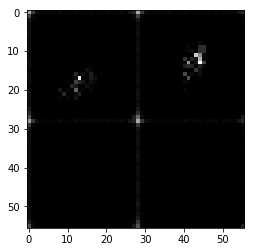

Steps 165 Discriminator Loss: 0.2214 Generator Loss: 2.7723
Steps 170 Discriminator Loss: 0.4169 Generator Loss: 1.7979
Steps 175 Discriminator Loss: 0.8361 Generator Loss: 1.7794
Steps 180 Discriminator Loss: 1.5137 Generator Loss: 0.4065


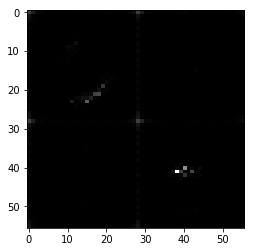

Steps 185 Discriminator Loss: 0.4316 Generator Loss: 2.0094
Steps 190 Discriminator Loss: 0.2595 Generator Loss: 2.6517
Steps 195 Discriminator Loss: 0.3955 Generator Loss: 1.9082
Steps 200 Discriminator Loss: 1.3478 Generator Loss: 0.4477


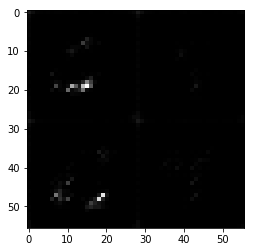

Steps 205 Discriminator Loss: 0.4583 Generator Loss: 1.4720
Steps 210 Discriminator Loss: 0.2413 Generator Loss: 2.3837
Steps 215 Discriminator Loss: 0.2786 Generator Loss: 2.3822
Steps 220 Discriminator Loss: 1.1107 Generator Loss: 0.5288


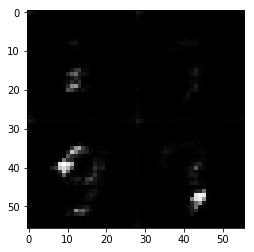

Steps 225 Discriminator Loss: 2.2534 Generator Loss: 0.2972
Steps 230 Discriminator Loss: 0.1519 Generator Loss: 4.6021
Steps 235 Discriminator Loss: 0.2208 Generator Loss: 2.5427
Steps 240 Discriminator Loss: 0.1906 Generator Loss: 2.5441


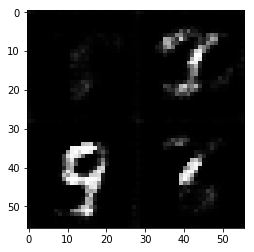

Steps 245 Discriminator Loss: 0.1031 Generator Loss: 3.3339
Steps 250 Discriminator Loss: 0.0734 Generator Loss: 4.0499
Steps 255 Discriminator Loss: 0.1723 Generator Loss: 2.4603
Steps 260 Discriminator Loss: 0.0879 Generator Loss: 4.1970


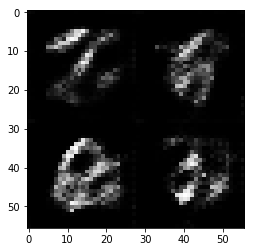

Steps 265 Discriminator Loss: 0.0279 Generator Loss: 5.2714
Steps 270 Discriminator Loss: 0.0731 Generator Loss: 3.7536
Steps 275 Discriminator Loss: 0.0781 Generator Loss: 4.3847
Steps 280 Discriminator Loss: 0.0640 Generator Loss: 4.1733


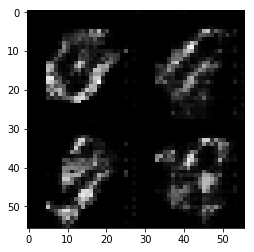

Steps 285 Discriminator Loss: 0.0450 Generator Loss: 3.6885
Steps 290 Discriminator Loss: 0.1249 Generator Loss: 2.3880
Steps 295 Discriminator Loss: 0.0290 Generator Loss: 4.7797
Steps 300 Discriminator Loss: 0.0363 Generator Loss: 4.7242


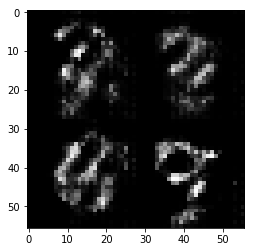

Steps 305 Discriminator Loss: 0.0210 Generator Loss: 5.0121
Steps 310 Discriminator Loss: 0.0547 Generator Loss: 4.1350
Steps 315 Discriminator Loss: 0.0844 Generator Loss: 2.9495
Steps 320 Discriminator Loss: 0.0732 Generator Loss: 3.4514


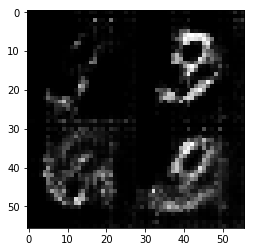

Steps 325 Discriminator Loss: 0.0473 Generator Loss: 3.8757
Steps 330 Discriminator Loss: 0.0499 Generator Loss: 3.9437
Steps 335 Discriminator Loss: 0.1116 Generator Loss: 2.9115
Steps 340 Discriminator Loss: 0.0234 Generator Loss: 4.9256


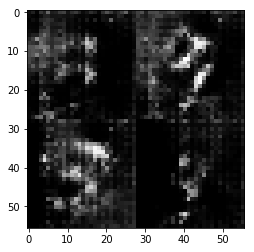

Steps 345 Discriminator Loss: 3.4958 Generator Loss: 0.0800
Steps 350 Discriminator Loss: 0.6378 Generator Loss: 1.3250
Steps 355 Discriminator Loss: 0.0778 Generator Loss: 3.2364
Steps 360 Discriminator Loss: 0.0877 Generator Loss: 3.3953


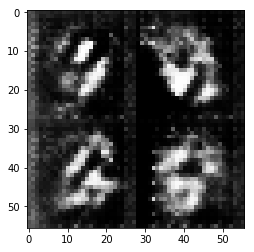

Steps 365 Discriminator Loss: 0.1183 Generator Loss: 3.4332
Steps 370 Discriminator Loss: 0.0816 Generator Loss: 4.6851
Steps 375 Discriminator Loss: 0.0961 Generator Loss: 4.3553
Steps 380 Discriminator Loss: 0.1442 Generator Loss: 3.8200


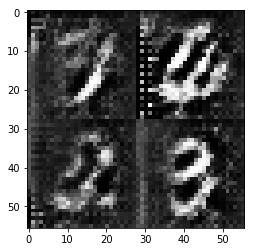

Steps 385 Discriminator Loss: 0.1846 Generator Loss: 2.9714
Steps 390 Discriminator Loss: 0.1926 Generator Loss: 2.6248
Steps 395 Discriminator Loss: 0.2224 Generator Loss: 2.7836
Steps 400 Discriminator Loss: 0.2623 Generator Loss: 6.9832


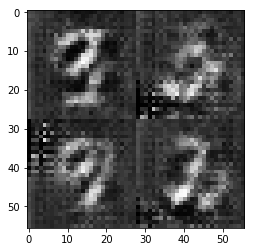

Steps 405 Discriminator Loss: 0.3648 Generator Loss: 2.7465
Steps 410 Discriminator Loss: 0.0341 Generator Loss: 7.4751
Steps 415 Discriminator Loss: 0.0670 Generator Loss: 5.1527
Steps 420 Discriminator Loss: 0.0389 Generator Loss: 7.5698


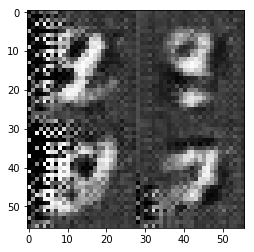

Steps 425 Discriminator Loss: 0.1725 Generator Loss: 3.1439
Steps 430 Discriminator Loss: 0.2328 Generator Loss: 3.2949
Steps 435 Discriminator Loss: 0.0313 Generator Loss: 5.9670
Steps 440 Discriminator Loss: 0.0795 Generator Loss: 4.4700


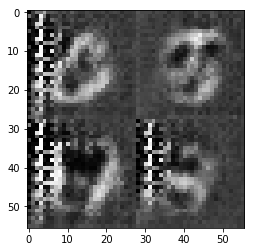

Steps 445 Discriminator Loss: 0.0897 Generator Loss: 4.5288
Steps 450 Discriminator Loss: 0.1139 Generator Loss: 3.3646
Steps 455 Discriminator Loss: 0.0679 Generator Loss: 4.1641
Steps 460 Discriminator Loss: 0.0544 Generator Loss: 4.6062


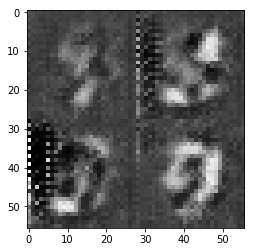

Steps 465 Discriminator Loss: 0.0449 Generator Loss: 6.2665
Steps 470 Discriminator Loss: 0.3145 Generator Loss: 3.2893
Steps 475 Discriminator Loss: 0.0847 Generator Loss: 5.3358
Steps 480 Discriminator Loss: 0.0211 Generator Loss: 7.5842


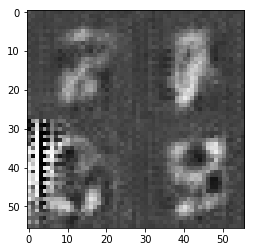

Steps 485 Discriminator Loss: 0.0481 Generator Loss: 9.2261
Steps 490 Discriminator Loss: 0.0416 Generator Loss: 5.3946
Steps 495 Discriminator Loss: 0.0988 Generator Loss: 3.4533
Steps 500 Discriminator Loss: 0.0134 Generator Loss: 9.6369


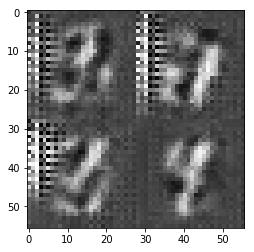

Steps 505 Discriminator Loss: 0.0434 Generator Loss: 5.4233
Steps 510 Discriminator Loss: 0.0257 Generator Loss: 8.0549
Steps 515 Discriminator Loss: 0.0123 Generator Loss: 7.5756
Steps 520 Discriminator Loss: 0.0241 Generator Loss: 6.5675


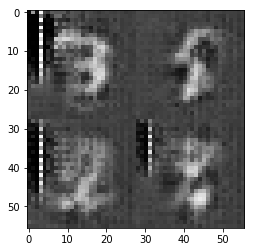

Steps 525 Discriminator Loss: 0.1124 Generator Loss: 4.4014
Steps 530 Discriminator Loss: 0.0572 Generator Loss: 4.5893
Steps 535 Discriminator Loss: 0.0240 Generator Loss: 7.0708
Steps 540 Discriminator Loss: 0.0817 Generator Loss: 4.6396


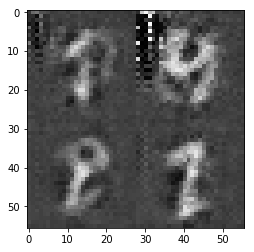

Steps 545 Discriminator Loss: 0.0778 Generator Loss: 3.7491
Steps 550 Discriminator Loss: 0.1029 Generator Loss: 4.6769
Steps 555 Discriminator Loss: 0.1539 Generator Loss: 2.9406
Steps 560 Discriminator Loss: 0.0928 Generator Loss: 4.5396


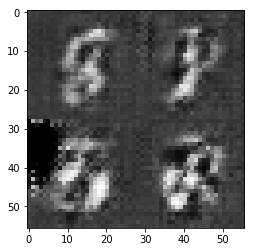

Steps 565 Discriminator Loss: 0.1342 Generator Loss: 6.7433
Steps 570 Discriminator Loss: 0.0238 Generator Loss: 4.9191
Steps 575 Discriminator Loss: 0.0311 Generator Loss: 5.0916
Steps 580 Discriminator Loss: 0.0526 Generator Loss: 5.2635


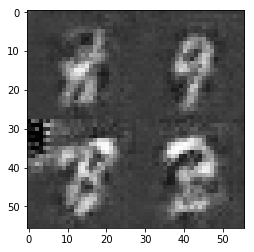

Steps 585 Discriminator Loss: 0.1368 Generator Loss: 3.3424
Steps 590 Discriminator Loss: 0.0805 Generator Loss: 4.8629
Steps 595 Discriminator Loss: 3.5649 Generator Loss: 0.0921
Steps 600 Discriminator Loss: 1.1091 Generator Loss: 2.5462


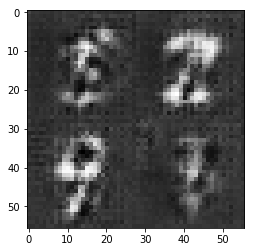

Steps 605 Discriminator Loss: 0.9295 Generator Loss: 0.7823
Steps 610 Discriminator Loss: 0.3864 Generator Loss: 2.1783
Steps 615 Discriminator Loss: 0.1418 Generator Loss: 3.2207
Steps 620 Discriminator Loss: 0.1987 Generator Loss: 2.4426


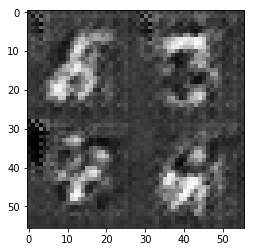

Steps 625 Discriminator Loss: 0.1660 Generator Loss: 2.8263
Steps 630 Discriminator Loss: 0.0357 Generator Loss: 6.3168
Steps 635 Discriminator Loss: 0.0777 Generator Loss: 3.8567
Steps 640 Discriminator Loss: 0.0941 Generator Loss: 3.3744


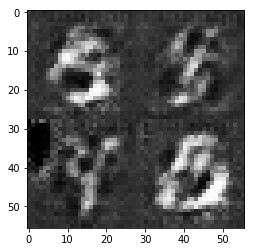

Steps 645 Discriminator Loss: 0.1137 Generator Loss: 3.1539
Steps 650 Discriminator Loss: 0.0820 Generator Loss: 3.6324
Steps 655 Discriminator Loss: 0.0966 Generator Loss: 3.3971
Steps 660 Discriminator Loss: 0.0368 Generator Loss: 4.5729


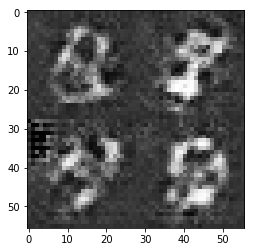

Steps 665 Discriminator Loss: 0.0736 Generator Loss: 3.9917
Steps 670 Discriminator Loss: 0.1007 Generator Loss: 3.2589
Steps 675 Discriminator Loss: 0.0672 Generator Loss: 4.2032
Steps 680 Discriminator Loss: 0.0992 Generator Loss: 5.0736


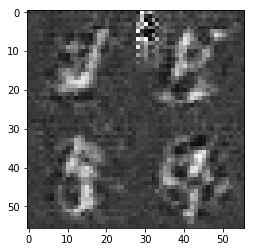

Steps 685 Discriminator Loss: 0.4264 Generator Loss: 2.1268
Steps 690 Discriminator Loss: 0.4624 Generator Loss: 3.9818
Steps 695 Discriminator Loss: 0.3193 Generator Loss: 1.9935
Steps 700 Discriminator Loss: 0.2160 Generator Loss: 2.6281


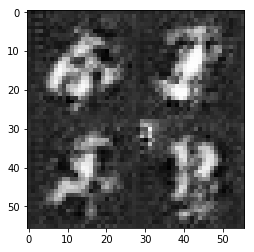

Steps 705 Discriminator Loss: 0.4990 Generator Loss: 1.2739
Steps 710 Discriminator Loss: 0.0780 Generator Loss: 3.4378
Steps 715 Discriminator Loss: 0.0904 Generator Loss: 3.6622
Steps 720 Discriminator Loss: 0.0715 Generator Loss: 3.3487


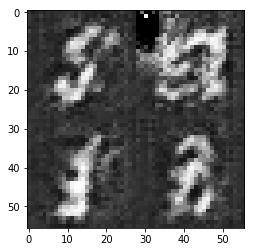

Steps 725 Discriminator Loss: 0.0895 Generator Loss: 3.2528
Steps 730 Discriminator Loss: 0.0539 Generator Loss: 3.8265
Steps 735 Discriminator Loss: 0.0742 Generator Loss: 3.7038
Steps 740 Discriminator Loss: 0.0459 Generator Loss: 4.2256


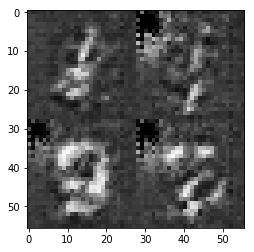

Steps 745 Discriminator Loss: 0.0308 Generator Loss: 6.1025
Steps 750 Discriminator Loss: 0.0281 Generator Loss: 4.9751
Steps 755 Discriminator Loss: 0.0322 Generator Loss: 5.4227
Steps 760 Discriminator Loss: 0.0197 Generator Loss: 7.3131


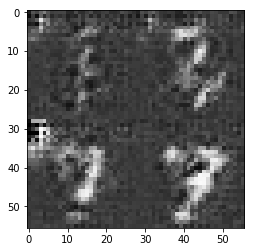

Steps 765 Discriminator Loss: 0.0267 Generator Loss: 7.7180
Steps 770 Discriminator Loss: 0.0407 Generator Loss: 4.6512
Steps 775 Discriminator Loss: 0.1402 Generator Loss: 3.4041
Steps 780 Discriminator Loss: 0.0240 Generator Loss: 5.7966


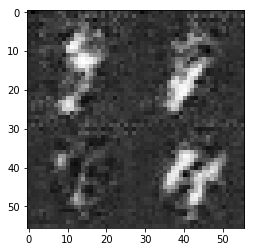

Steps 785 Discriminator Loss: 0.0205 Generator Loss: 6.9393
Steps 790 Discriminator Loss: 0.1146 Generator Loss: 3.5735
Steps 795 Discriminator Loss: 0.0609 Generator Loss: 4.7579
Steps 800 Discriminator Loss: 0.0377 Generator Loss: 5.1589


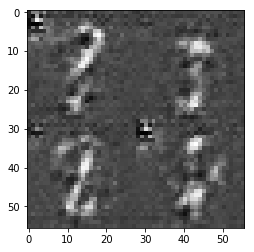

Steps 805 Discriminator Loss: 0.0760 Generator Loss: 3.8612
Steps 810 Discriminator Loss: 0.1813 Generator Loss: 3.0159
Steps 815 Discriminator Loss: 0.0207 Generator Loss: 5.6608
Steps 820 Discriminator Loss: 0.0528 Generator Loss: 4.6043


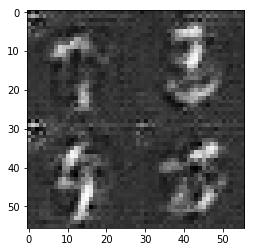

Steps 825 Discriminator Loss: 0.0248 Generator Loss: 5.5681
Steps 830 Discriminator Loss: 0.0448 Generator Loss: 5.1826
Steps 835 Discriminator Loss: 0.0514 Generator Loss: 4.7036
Steps 840 Discriminator Loss: 0.2298 Generator Loss: 2.1649


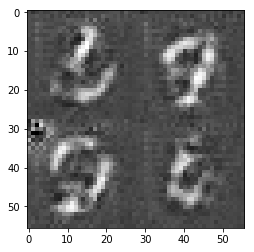

Steps 845 Discriminator Loss: 0.2888 Generator Loss: 2.1474
Steps 850 Discriminator Loss: 0.0175 Generator Loss: 7.4868
Steps 855 Discriminator Loss: 0.0276 Generator Loss: 5.4843
Steps 860 Discriminator Loss: 0.0140 Generator Loss: 7.5695


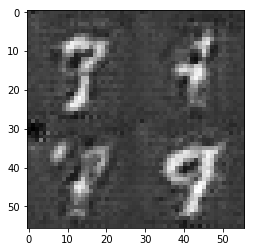

Steps 865 Discriminator Loss: 0.0489 Generator Loss: 5.3393
Steps 870 Discriminator Loss: 0.0416 Generator Loss: 5.3371
Steps 875 Discriminator Loss: 0.0809 Generator Loss: 3.4976
Steps 880 Discriminator Loss: 0.0150 Generator Loss: 6.5224


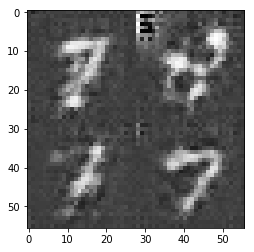

Steps 885 Discriminator Loss: 0.1593 Generator Loss: 2.6135
Steps 890 Discriminator Loss: 0.6810 Generator Loss: 3.0438
Steps 895 Discriminator Loss: 1.5351 Generator Loss: 0.4812
Steps 900 Discriminator Loss: 1.8208 Generator Loss: 0.5227


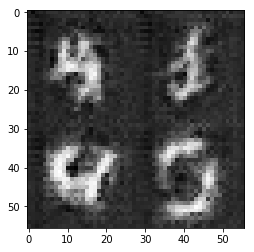

Steps 905 Discriminator Loss: 1.1578 Generator Loss: 1.2144
Steps 910 Discriminator Loss: 1.1144 Generator Loss: 0.9082
Steps 915 Discriminator Loss: 1.2863 Generator Loss: 2.3772
Steps 920 Discriminator Loss: 1.2340 Generator Loss: 0.5075


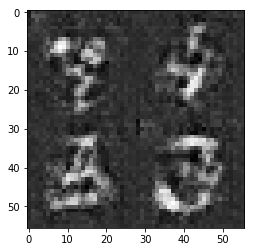

Steps 925 Discriminator Loss: 0.8859 Generator Loss: 2.0577
Steps 930 Discriminator Loss: 0.6149 Generator Loss: 1.3340
Steps 935 Discriminator Loss: 0.7138 Generator Loss: 1.0518
Finished Training. The result: 


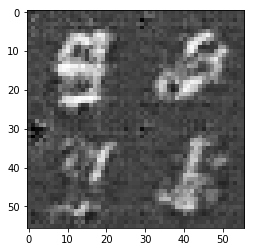

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Steps 5 Discriminator Loss: 2.0821 Generator Loss: 0.4819
Steps 10 Discriminator Loss: 0.6082 Generator Loss: 1.4153
Steps 15 Discriminator Loss: 1.0032 Generator Loss: 0.8141
Steps 20 Discriminator Loss: 0.3457 Generator Loss: 2.5532


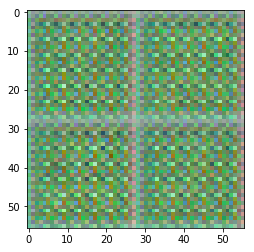

Steps 25 Discriminator Loss: 0.7938 Generator Loss: 1.1893
Steps 30 Discriminator Loss: 0.3581 Generator Loss: 2.4067
Steps 35 Discriminator Loss: 0.5592 Generator Loss: 5.4316
Steps 40 Discriminator Loss: 1.0708 Generator Loss: 0.6243


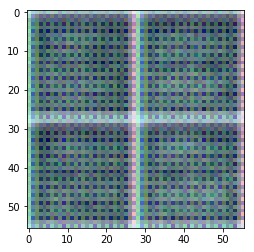

Steps 45 Discriminator Loss: 0.7375 Generator Loss: 1.0042
Steps 50 Discriminator Loss: 0.6243 Generator Loss: 1.2480
Steps 55 Discriminator Loss: 0.6235 Generator Loss: 1.3690
Steps 60 Discriminator Loss: 0.9145 Generator Loss: 0.7088


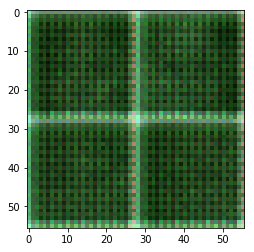

Steps 65 Discriminator Loss: 0.2672 Generator Loss: 2.3752
Steps 70 Discriminator Loss: 0.3876 Generator Loss: 1.7904
Steps 75 Discriminator Loss: 0.4942 Generator Loss: 1.2536
Steps 80 Discriminator Loss: 0.2334 Generator Loss: 1.9877


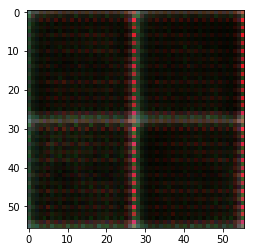

Steps 85 Discriminator Loss: 0.1506 Generator Loss: 2.9036
Steps 90 Discriminator Loss: 0.1673 Generator Loss: 2.7943
Steps 95 Discriminator Loss: 0.0740 Generator Loss: 4.1342
Steps 100 Discriminator Loss: 0.0644 Generator Loss: 4.8254


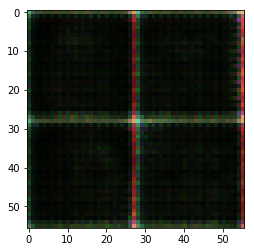

Steps 105 Discriminator Loss: 0.0906 Generator Loss: 3.1882
Steps 110 Discriminator Loss: 0.3114 Generator Loss: 1.4768
Steps 115 Discriminator Loss: 0.0254 Generator Loss: 4.3427
Steps 120 Discriminator Loss: 0.1364 Generator Loss: 2.2651


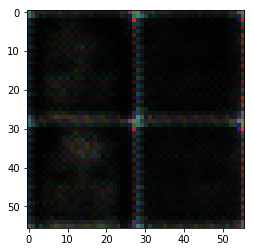

Steps 125 Discriminator Loss: 0.0410 Generator Loss: 4.6415
Steps 130 Discriminator Loss: 0.0288 Generator Loss: 5.9497
Steps 135 Discriminator Loss: 0.0359 Generator Loss: 4.0848
Steps 140 Discriminator Loss: 0.0323 Generator Loss: 10.1516


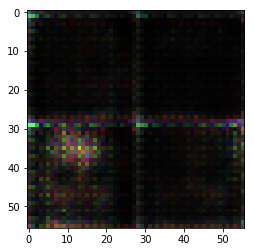

Steps 145 Discriminator Loss: 0.0329 Generator Loss: 6.2263
Steps 150 Discriminator Loss: 0.0114 Generator Loss: 5.2715
Steps 155 Discriminator Loss: 0.0159 Generator Loss: 5.3498
Steps 160 Discriminator Loss: 0.1339 Generator Loss: 2.4871


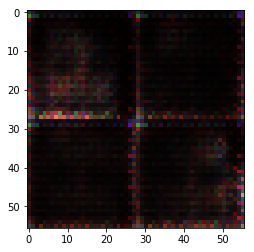

Steps 165 Discriminator Loss: 0.0105 Generator Loss: 5.3123
Steps 170 Discriminator Loss: 0.0334 Generator Loss: 6.3970
Steps 175 Discriminator Loss: 0.0197 Generator Loss: 7.3173
Steps 180 Discriminator Loss: 0.0484 Generator Loss: 3.4657


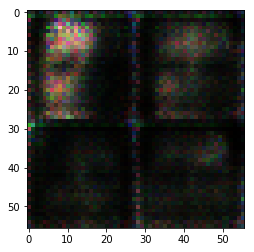

Steps 185 Discriminator Loss: 0.0251 Generator Loss: 5.5272
Steps 190 Discriminator Loss: 0.0272 Generator Loss: 5.2611
Steps 195 Discriminator Loss: 0.0299 Generator Loss: 3.9900
Steps 200 Discriminator Loss: 0.0102 Generator Loss: 6.2590


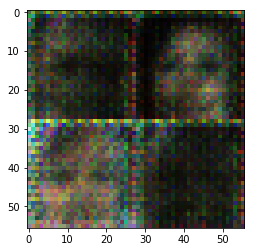

Steps 205 Discriminator Loss: 0.0713 Generator Loss: 3.0616
Steps 210 Discriminator Loss: 0.1586 Generator Loss: 9.7357
Steps 215 Discriminator Loss: 0.0105 Generator Loss: 7.3490
Steps 220 Discriminator Loss: 0.0063 Generator Loss: 8.5593


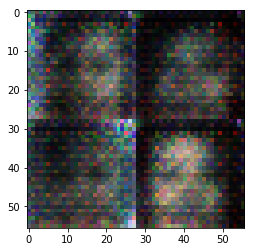

Steps 225 Discriminator Loss: 0.0050 Generator Loss: 6.1040
Steps 230 Discriminator Loss: 0.2782 Generator Loss: 1.6799
Steps 235 Discriminator Loss: 1.1012 Generator Loss: 3.8719
Steps 240 Discriminator Loss: 0.1378 Generator Loss: 4.3157


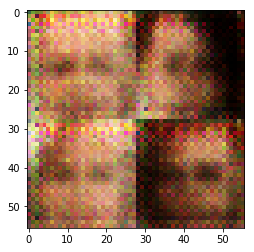

Steps 245 Discriminator Loss: 0.5812 Generator Loss: 1.3032
Steps 250 Discriminator Loss: 0.2474 Generator Loss: 2.3929
Steps 255 Discriminator Loss: 4.2626 Generator Loss: 13.3262
Steps 260 Discriminator Loss: 0.2807 Generator Loss: 2.6119


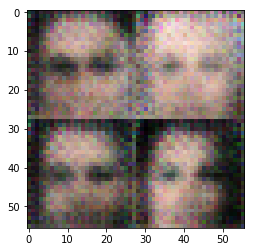

Steps 265 Discriminator Loss: 1.2540 Generator Loss: 0.5316
Steps 270 Discriminator Loss: 0.0316 Generator Loss: 6.9968
Steps 275 Discriminator Loss: 1.2265 Generator Loss: 0.5198
Steps 280 Discriminator Loss: 0.0026 Generator Loss: 15.0832


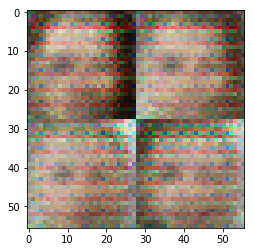

Steps 285 Discriminator Loss: 0.0089 Generator Loss: 6.2936
Steps 290 Discriminator Loss: 1.6274 Generator Loss: 0.3188
Steps 295 Discriminator Loss: 0.0018 Generator Loss: 7.8919
Steps 300 Discriminator Loss: 0.0055 Generator Loss: 9.0454


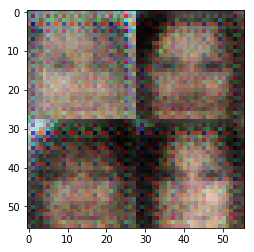

Steps 305 Discriminator Loss: 0.3730 Generator Loss: 9.1282
Steps 310 Discriminator Loss: 0.3680 Generator Loss: 1.9042
Steps 315 Discriminator Loss: 0.2804 Generator Loss: 2.2411
Steps 320 Discriminator Loss: 0.0166 Generator Loss: 7.0596


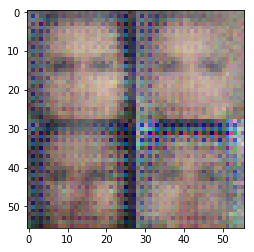

Steps 325 Discriminator Loss: 0.1773 Generator Loss: 3.3227
Steps 330 Discriminator Loss: 0.4012 Generator Loss: 5.4870
Steps 335 Discriminator Loss: 0.0476 Generator Loss: 4.3041
Steps 340 Discriminator Loss: 0.5709 Generator Loss: 2.3149


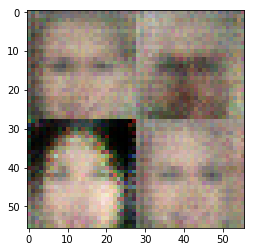

Steps 345 Discriminator Loss: 0.0697 Generator Loss: 4.6263
Steps 350 Discriminator Loss: 0.6002 Generator Loss: 7.2404
Steps 355 Discriminator Loss: 0.8254 Generator Loss: 1.1044
Steps 360 Discriminator Loss: 1.7313 Generator Loss: 4.7798


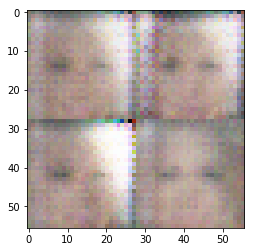

Steps 365 Discriminator Loss: 0.0408 Generator Loss: 6.0812
Steps 370 Discriminator Loss: 0.4802 Generator Loss: 1.4563
Steps 375 Discriminator Loss: 0.0642 Generator Loss: 6.6605
Steps 380 Discriminator Loss: 0.1213 Generator Loss: 4.1960


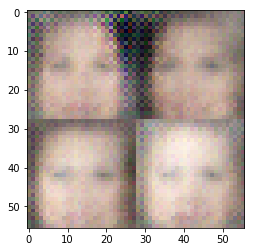

Steps 385 Discriminator Loss: 0.2616 Generator Loss: 1.8497
Steps 390 Discriminator Loss: 0.1367 Generator Loss: 3.0544
Steps 395 Discriminator Loss: 0.1160 Generator Loss: 3.5987
Steps 400 Discriminator Loss: 0.0368 Generator Loss: 4.6013


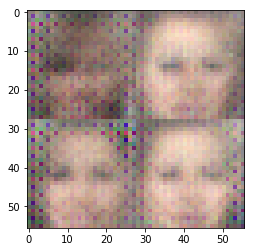

Steps 405 Discriminator Loss: 0.0824 Generator Loss: 4.4819
Steps 410 Discriminator Loss: 0.0487 Generator Loss: 7.0659
Steps 415 Discriminator Loss: 0.0523 Generator Loss: 3.8969
Steps 420 Discriminator Loss: 1.0460 Generator Loss: 0.6935


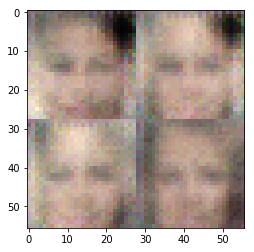

Steps 425 Discriminator Loss: 0.0703 Generator Loss: 6.1802
Steps 430 Discriminator Loss: 0.4751 Generator Loss: 1.3917
Steps 435 Discriminator Loss: 0.5386 Generator Loss: 5.9345
Steps 440 Discriminator Loss: 0.0639 Generator Loss: 8.2064


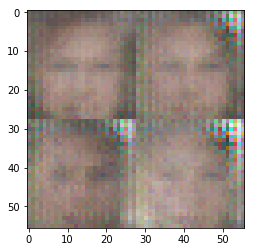

Steps 445 Discriminator Loss: 0.2831 Generator Loss: 2.0509
Steps 450 Discriminator Loss: 0.0647 Generator Loss: 7.5994
Steps 455 Discriminator Loss: 0.0719 Generator Loss: 3.7422
Steps 460 Discriminator Loss: 0.3321 Generator Loss: 3.1142


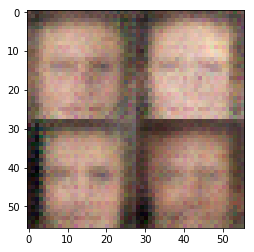

Steps 465 Discriminator Loss: 0.0759 Generator Loss: 3.6310
Steps 470 Discriminator Loss: 0.9685 Generator Loss: 11.5291
Steps 475 Discriminator Loss: 0.9435 Generator Loss: 0.6361
Steps 480 Discriminator Loss: 0.4081 Generator Loss: 2.5523


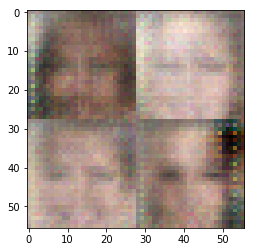

Steps 485 Discriminator Loss: 0.0811 Generator Loss: 3.9236
Steps 490 Discriminator Loss: 0.2372 Generator Loss: 4.6352
Steps 495 Discriminator Loss: 0.0555 Generator Loss: 4.8697
Steps 500 Discriminator Loss: 0.1980 Generator Loss: 3.2235


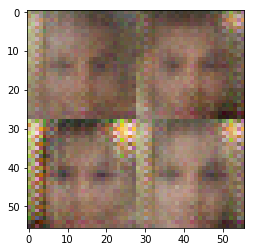

Steps 505 Discriminator Loss: 0.3354 Generator Loss: 1.9196
Steps 510 Discriminator Loss: 0.2034 Generator Loss: 2.8508
Steps 515 Discriminator Loss: 0.1152 Generator Loss: 8.0713
Steps 520 Discriminator Loss: 0.0382 Generator Loss: 4.6631


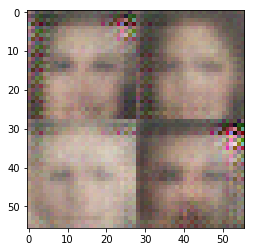

Steps 525 Discriminator Loss: 0.2241 Generator Loss: 3.1188
Steps 530 Discriminator Loss: 0.1895 Generator Loss: 2.1051
Steps 535 Discriminator Loss: 0.0471 Generator Loss: 5.7107
Steps 540 Discriminator Loss: 0.3022 Generator Loss: 6.4996


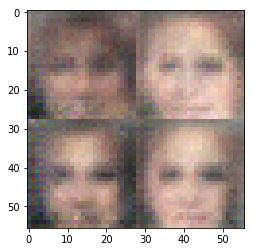

Steps 545 Discriminator Loss: 0.1657 Generator Loss: 2.9020
Steps 550 Discriminator Loss: 0.5234 Generator Loss: 1.2233
Steps 555 Discriminator Loss: 0.0172 Generator Loss: 7.2360
Steps 560 Discriminator Loss: 0.1863 Generator Loss: 3.1104


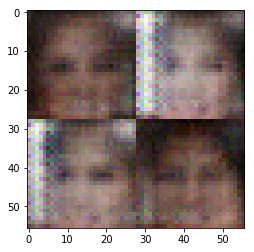

Steps 565 Discriminator Loss: 0.0492 Generator Loss: 6.5489
Steps 570 Discriminator Loss: 0.1297 Generator Loss: 3.9634
Steps 575 Discriminator Loss: 0.0471 Generator Loss: 10.1087
Steps 580 Discriminator Loss: 0.1144 Generator Loss: 3.1812


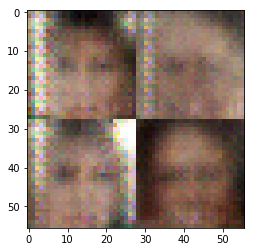

Steps 585 Discriminator Loss: 0.3315 Generator Loss: 2.6179
Steps 590 Discriminator Loss: 0.0116 Generator Loss: 10.9040
Steps 595 Discriminator Loss: 0.8108 Generator Loss: 6.3934
Steps 600 Discriminator Loss: 0.2442 Generator Loss: 6.3113


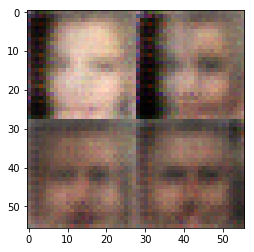

Steps 605 Discriminator Loss: 5.0660 Generator Loss: 6.8660
Steps 610 Discriminator Loss: 0.1371 Generator Loss: 2.5044
Steps 615 Discriminator Loss: 0.3413 Generator Loss: 2.1420
Steps 620 Discriminator Loss: 0.0466 Generator Loss: 6.5890


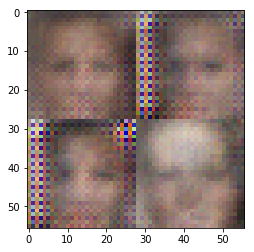

Steps 625 Discriminator Loss: 0.8221 Generator Loss: 2.4427
Steps 630 Discriminator Loss: 0.1916 Generator Loss: 5.3401
Steps 635 Discriminator Loss: 0.2079 Generator Loss: 2.1169
Steps 640 Discriminator Loss: 0.0956 Generator Loss: 3.7538


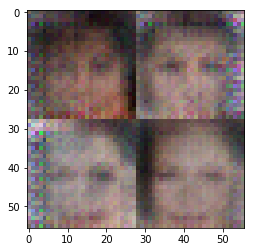

Steps 645 Discriminator Loss: 0.0282 Generator Loss: 11.4979
Steps 650 Discriminator Loss: 0.0900 Generator Loss: 3.3266
Steps 655 Discriminator Loss: 0.2530 Generator Loss: 6.2131
Steps 660 Discriminator Loss: 0.2840 Generator Loss: 3.3291


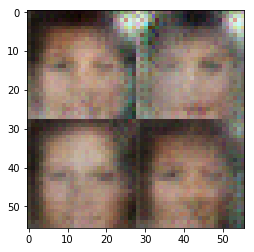

Steps 665 Discriminator Loss: 0.1914 Generator Loss: 3.2562
Steps 670 Discriminator Loss: 0.0952 Generator Loss: 3.3265
Steps 675 Discriminator Loss: 0.1554 Generator Loss: 5.9389
Steps 680 Discriminator Loss: 0.4014 Generator Loss: 1.7996


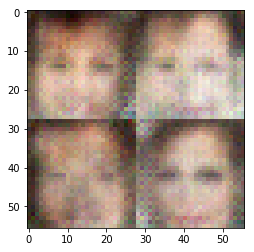

Steps 685 Discriminator Loss: 0.0572 Generator Loss: 4.1834
Steps 690 Discriminator Loss: 0.1196 Generator Loss: 5.8231
Steps 695 Discriminator Loss: 0.0453 Generator Loss: 4.1451
Steps 700 Discriminator Loss: 0.5419 Generator Loss: 1.5515


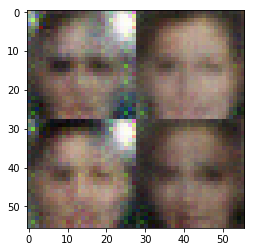

Steps 705 Discriminator Loss: 0.1638 Generator Loss: 2.7634
Steps 710 Discriminator Loss: 0.0444 Generator Loss: 4.4340
Steps 715 Discriminator Loss: 0.0276 Generator Loss: 7.6160
Steps 720 Discriminator Loss: 0.0335 Generator Loss: 6.5343


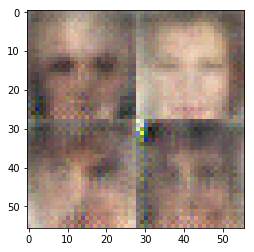

Steps 725 Discriminator Loss: 0.1225 Generator Loss: 3.8131
Steps 730 Discriminator Loss: 0.0634 Generator Loss: 4.6343
Steps 735 Discriminator Loss: 0.5343 Generator Loss: 7.7506
Steps 740 Discriminator Loss: 0.8159 Generator Loss: 0.9863


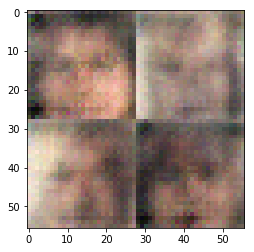

Steps 745 Discriminator Loss: 0.1819 Generator Loss: 3.6641
Steps 750 Discriminator Loss: 1.0370 Generator Loss: 7.4212
Steps 755 Discriminator Loss: 0.3453 Generator Loss: 2.2246
Steps 760 Discriminator Loss: 0.2476 Generator Loss: 4.5993


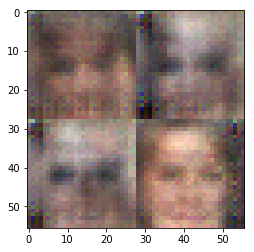

Steps 765 Discriminator Loss: 1.0642 Generator Loss: 0.8786
Steps 770 Discriminator Loss: 0.0827 Generator Loss: 5.3883
Steps 775 Discriminator Loss: 1.0840 Generator Loss: 0.6041
Steps 780 Discriminator Loss: 0.1005 Generator Loss: 3.1259


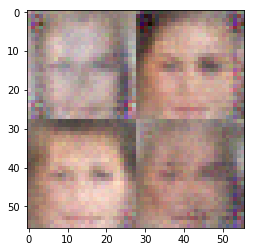

Steps 785 Discriminator Loss: 0.7365 Generator Loss: 2.6287
Steps 790 Discriminator Loss: 0.2607 Generator Loss: 1.9639
Steps 795 Discriminator Loss: 0.1645 Generator Loss: 3.6314
Steps 800 Discriminator Loss: 0.3699 Generator Loss: 1.8277


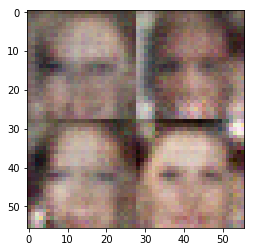

Steps 805 Discriminator Loss: 1.4533 Generator Loss: 0.5167
Steps 810 Discriminator Loss: 0.4243 Generator Loss: 2.3492
Steps 815 Discriminator Loss: 0.1753 Generator Loss: 2.9096
Steps 820 Discriminator Loss: 0.0670 Generator Loss: 7.2790


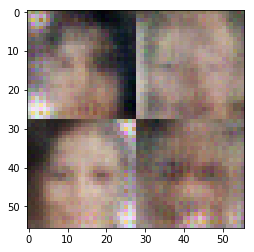

Steps 825 Discriminator Loss: 0.1788 Generator Loss: 8.2770
Steps 830 Discriminator Loss: 0.2161 Generator Loss: 10.7919
Steps 835 Discriminator Loss: 0.1370 Generator Loss: 3.2223
Steps 840 Discriminator Loss: 0.8333 Generator Loss: 2.3001


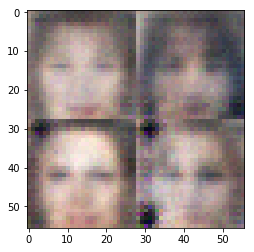

Steps 845 Discriminator Loss: 0.0537 Generator Loss: 10.2557
Steps 850 Discriminator Loss: 0.1434 Generator Loss: 9.3674
Steps 855 Discriminator Loss: 0.1138 Generator Loss: 5.2449
Steps 860 Discriminator Loss: 0.0695 Generator Loss: 6.3452


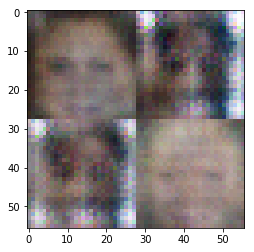

Steps 865 Discriminator Loss: 0.1851 Generator Loss: 11.9770
Steps 870 Discriminator Loss: 0.2311 Generator Loss: 12.4628
Steps 875 Discriminator Loss: 0.0338 Generator Loss: 6.1778
Steps 880 Discriminator Loss: 1.1177 Generator Loss: 3.3037


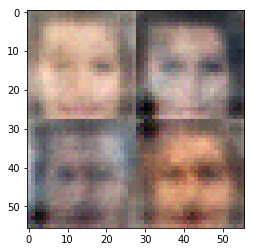

Steps 885 Discriminator Loss: 0.0140 Generator Loss: 7.6974
Steps 890 Discriminator Loss: 0.4819 Generator Loss: 1.9965
Steps 895 Discriminator Loss: 0.0341 Generator Loss: 5.1094
Steps 900 Discriminator Loss: 0.0555 Generator Loss: 4.9388


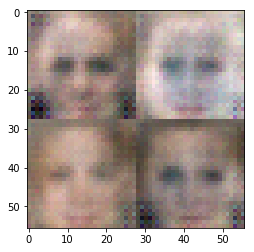

Steps 905 Discriminator Loss: 0.9456 Generator Loss: 0.8616
Steps 910 Discriminator Loss: 0.2809 Generator Loss: 2.2359
Steps 915 Discriminator Loss: 0.1637 Generator Loss: 2.7595
Steps 920 Discriminator Loss: 0.1894 Generator Loss: 2.7959


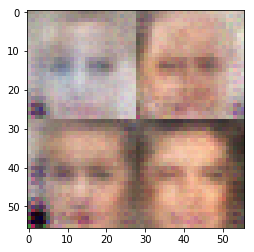

Steps 925 Discriminator Loss: 0.3173 Generator Loss: 2.1375
Steps 930 Discriminator Loss: 0.0455 Generator Loss: 8.3812
Steps 935 Discriminator Loss: 0.1230 Generator Loss: 6.0486
Steps 940 Discriminator Loss: 0.0269 Generator Loss: 5.5135


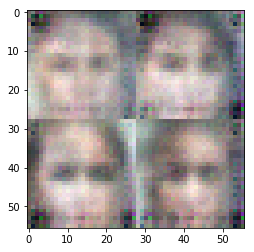

Steps 945 Discriminator Loss: 0.4270 Generator Loss: 1.5815
Steps 950 Discriminator Loss: 0.0165 Generator Loss: 7.2686
Steps 955 Discriminator Loss: 0.0405 Generator Loss: 7.4784
Steps 960 Discriminator Loss: 1.6577 Generator Loss: 0.3562


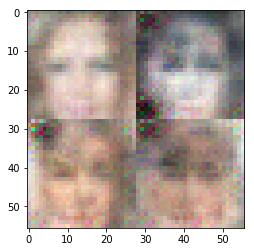

Steps 965 Discriminator Loss: 0.6408 Generator Loss: 1.0077
Steps 970 Discriminator Loss: 0.1247 Generator Loss: 3.6737
Steps 975 Discriminator Loss: 0.0290 Generator Loss: 6.9659
Steps 980 Discriminator Loss: 0.3200 Generator Loss: 2.3115


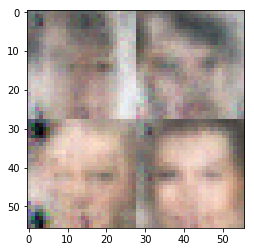

Steps 985 Discriminator Loss: 0.2972 Generator Loss: 1.9160
Steps 990 Discriminator Loss: 0.0368 Generator Loss: 5.8823
Steps 995 Discriminator Loss: 2.1895 Generator Loss: 0.1687
Steps 1000 Discriminator Loss: 0.5321 Generator Loss: 12.5341


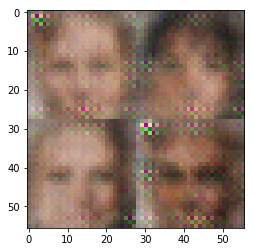

Steps 1005 Discriminator Loss: 0.0411 Generator Loss: 6.8318
Steps 1010 Discriminator Loss: 0.3020 Generator Loss: 1.9661
Steps 1015 Discriminator Loss: 0.2039 Generator Loss: 3.4827
Steps 1020 Discriminator Loss: 0.0934 Generator Loss: 3.4148


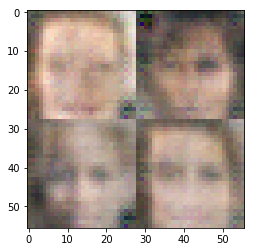

Steps 1025 Discriminator Loss: 0.7328 Generator Loss: 3.2352
Steps 1030 Discriminator Loss: 0.2996 Generator Loss: 2.1491
Steps 1035 Discriminator Loss: 0.1024 Generator Loss: 4.3329
Steps 1040 Discriminator Loss: 0.5353 Generator Loss: 2.5630


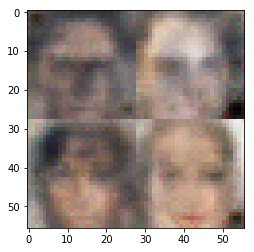

Steps 1045 Discriminator Loss: 0.6005 Generator Loss: 1.1959
Steps 1050 Discriminator Loss: 0.0208 Generator Loss: 5.6669
Steps 1055 Discriminator Loss: 0.1466 Generator Loss: 8.8094
Steps 1060 Discriminator Loss: 0.0912 Generator Loss: 3.2872


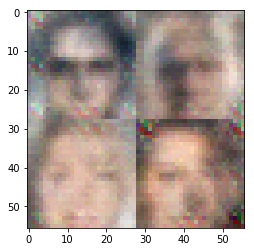

Steps 1065 Discriminator Loss: 0.1119 Generator Loss: 3.6169
Steps 1070 Discriminator Loss: 0.0374 Generator Loss: 5.4161
Steps 1075 Discriminator Loss: 0.0327 Generator Loss: 4.6530
Steps 1080 Discriminator Loss: 0.0577 Generator Loss: 3.7806


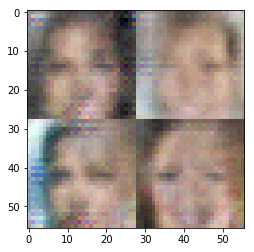

Steps 1085 Discriminator Loss: 0.5726 Generator Loss: 7.1726
Steps 1090 Discriminator Loss: 0.6588 Generator Loss: 10.4721
Steps 1095 Discriminator Loss: 0.0933 Generator Loss: 4.0576
Steps 1100 Discriminator Loss: 2.0036 Generator Loss: 5.0014


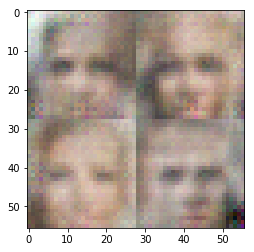

Steps 1105 Discriminator Loss: 0.4813 Generator Loss: 1.8259
Steps 1110 Discriminator Loss: 0.5771 Generator Loss: 3.3976
Steps 1115 Discriminator Loss: 0.1969 Generator Loss: 4.1942
Steps 1120 Discriminator Loss: 0.1501 Generator Loss: 3.4701


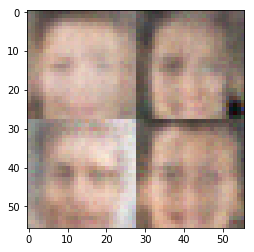

Steps 1125 Discriminator Loss: 0.1211 Generator Loss: 4.7860
Steps 1130 Discriminator Loss: 0.4813 Generator Loss: 1.3302
Steps 1135 Discriminator Loss: 0.9738 Generator Loss: 6.1003
Steps 1140 Discriminator Loss: 0.0476 Generator Loss: 6.4787


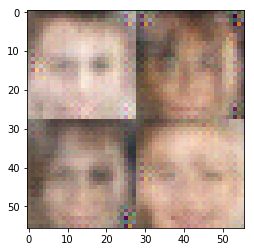

Steps 1145 Discriminator Loss: 0.2033 Generator Loss: 9.4103
Steps 1150 Discriminator Loss: 0.0979 Generator Loss: 3.2515
Steps 1155 Discriminator Loss: 0.2561 Generator Loss: 9.0239
Steps 1160 Discriminator Loss: 0.2523 Generator Loss: 2.3117


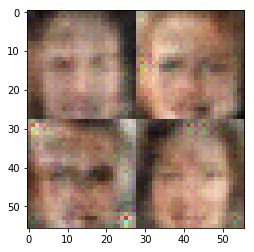

Steps 1165 Discriminator Loss: 0.3370 Generator Loss: 1.6828
Steps 1170 Discriminator Loss: 0.0176 Generator Loss: 6.4242
Steps 1175 Discriminator Loss: 0.0852 Generator Loss: 3.4961
Steps 1180 Discriminator Loss: 1.7952 Generator Loss: 0.7015


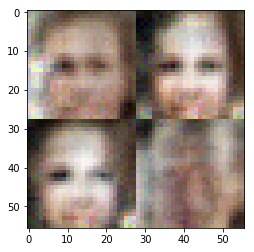

Steps 1185 Discriminator Loss: 2.6083 Generator Loss: 0.2091
Steps 1190 Discriminator Loss: 1.3211 Generator Loss: 0.8124
Steps 1195 Discriminator Loss: 0.3316 Generator Loss: 9.4160
Steps 1200 Discriminator Loss: 0.4453 Generator Loss: 1.8193


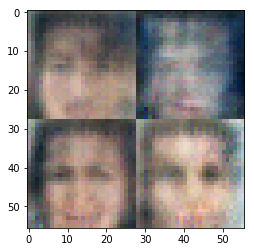

Steps 1205 Discriminator Loss: 1.7240 Generator Loss: 3.2969
Steps 1210 Discriminator Loss: 0.8145 Generator Loss: 4.8125
Steps 1215 Discriminator Loss: 0.7907 Generator Loss: 0.8078
Steps 1220 Discriminator Loss: 0.6270 Generator Loss: 1.1106


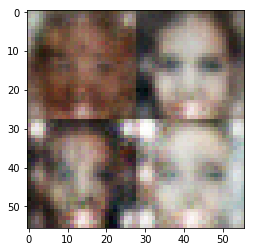

Steps 1225 Discriminator Loss: 0.1245 Generator Loss: 10.2936
Steps 1230 Discriminator Loss: 0.0258 Generator Loss: 12.5149
Steps 1235 Discriminator Loss: 0.1346 Generator Loss: 3.6226
Steps 1240 Discriminator Loss: 0.0285 Generator Loss: 6.8578


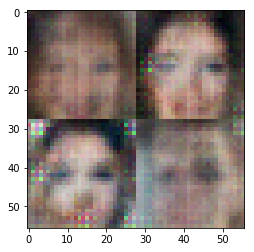

Steps 1245 Discriminator Loss: 0.0191 Generator Loss: 10.2110
Steps 1250 Discriminator Loss: 0.0747 Generator Loss: 4.5889
Steps 1255 Discriminator Loss: 0.0268 Generator Loss: 7.0563
Steps 1260 Discriminator Loss: 0.0460 Generator Loss: 9.9252


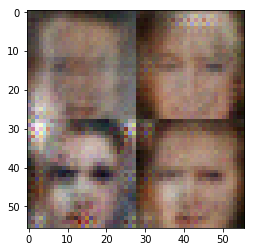

Steps 1265 Discriminator Loss: 0.0223 Generator Loss: 5.3544
Steps 1270 Discriminator Loss: 0.2423 Generator Loss: 5.7152
Steps 1275 Discriminator Loss: 0.0426 Generator Loss: 6.4123
Steps 1280 Discriminator Loss: 0.9464 Generator Loss: 0.6558


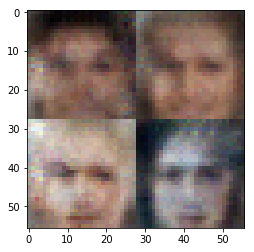

Steps 1285 Discriminator Loss: 0.0430 Generator Loss: 4.7301
Steps 1290 Discriminator Loss: 0.1363 Generator Loss: 14.1023
Steps 1295 Discriminator Loss: 0.0066 Generator Loss: 12.0603
Steps 1300 Discriminator Loss: 0.0466 Generator Loss: 3.5702


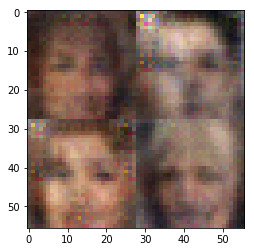

Steps 1305 Discriminator Loss: 1.6053 Generator Loss: 8.1731
Steps 1310 Discriminator Loss: 0.0473 Generator Loss: 6.0891
Steps 1315 Discriminator Loss: 0.1166 Generator Loss: 9.7467
Steps 1320 Discriminator Loss: 0.0240 Generator Loss: 11.9536


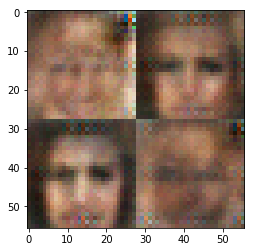

Steps 1325 Discriminator Loss: 0.0258 Generator Loss: 4.5146
Steps 1330 Discriminator Loss: 0.1210 Generator Loss: 4.6005
Steps 1335 Discriminator Loss: 0.3524 Generator Loss: 2.0016
Steps 1340 Discriminator Loss: 3.2140 Generator Loss: 0.0766


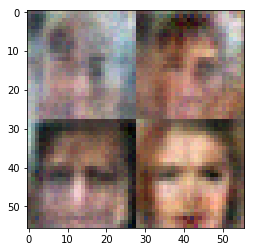

Steps 1345 Discriminator Loss: 0.0688 Generator Loss: 5.3968
Steps 1350 Discriminator Loss: 0.0057 Generator Loss: 12.3891
Steps 1355 Discriminator Loss: 0.2472 Generator Loss: 1.9327
Steps 1360 Discriminator Loss: 0.0278 Generator Loss: 7.1817


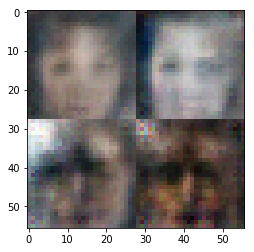

Steps 1365 Discriminator Loss: 0.0555 Generator Loss: 14.7541
Steps 1370 Discriminator Loss: 0.0249 Generator Loss: 9.6973
Steps 1375 Discriminator Loss: 0.0528 Generator Loss: 10.9003
Steps 1380 Discriminator Loss: 0.1401 Generator Loss: 12.5551


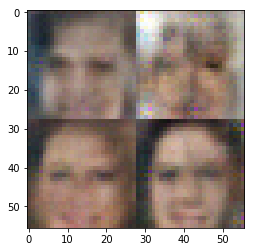

Steps 1385 Discriminator Loss: 0.0209 Generator Loss: 12.7038
Steps 1390 Discriminator Loss: 0.0210 Generator Loss: 8.6854
Steps 1395 Discriminator Loss: 0.0290 Generator Loss: 7.6017
Steps 1400 Discriminator Loss: 0.0349 Generator Loss: 5.0982


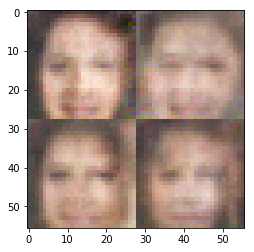

Steps 1405 Discriminator Loss: 0.0164 Generator Loss: 8.4724
Steps 1410 Discriminator Loss: 0.0334 Generator Loss: 4.8919
Steps 1415 Discriminator Loss: 0.0181 Generator Loss: 5.9420
Steps 1420 Discriminator Loss: 0.0375 Generator Loss: 6.5055


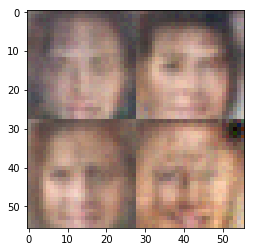

Steps 1425 Discriminator Loss: 1.7235 Generator Loss: 3.7379
Steps 1430 Discriminator Loss: 0.0080 Generator Loss: 9.6366
Steps 1435 Discriminator Loss: 0.1710 Generator Loss: 2.6454
Steps 1440 Discriminator Loss: 0.1511 Generator Loss: 3.5504


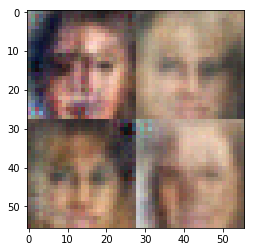

Steps 1445 Discriminator Loss: 0.1881 Generator Loss: 5.4050
Steps 1450 Discriminator Loss: 0.0950 Generator Loss: 10.1493
Steps 1455 Discriminator Loss: 0.2008 Generator Loss: 2.2031
Steps 1460 Discriminator Loss: 0.1510 Generator Loss: 4.2382


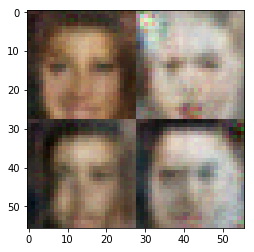

Steps 1465 Discriminator Loss: 0.0335 Generator Loss: 4.7283
Steps 1470 Discriminator Loss: 0.0436 Generator Loss: 6.6521
Steps 1475 Discriminator Loss: 0.0339 Generator Loss: 13.8342
Steps 1480 Discriminator Loss: 0.0442 Generator Loss: 4.5029


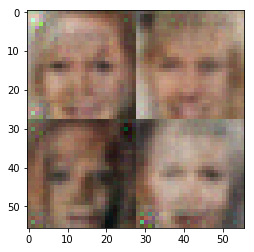

Steps 1485 Discriminator Loss: 0.7867 Generator Loss: 0.8624
Steps 1490 Discriminator Loss: 0.0535 Generator Loss: 4.0045
Steps 1495 Discriminator Loss: 0.0837 Generator Loss: 3.2879
Steps 1500 Discriminator Loss: 0.0444 Generator Loss: 6.0313


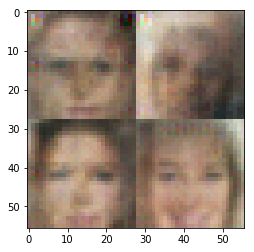

Steps 1505 Discriminator Loss: 0.3298 Generator Loss: 3.2229
Steps 1510 Discriminator Loss: 0.0088 Generator Loss: 15.3289
Steps 1515 Discriminator Loss: 0.0413 Generator Loss: 6.5506
Steps 1520 Discriminator Loss: 0.0217 Generator Loss: 12.0420


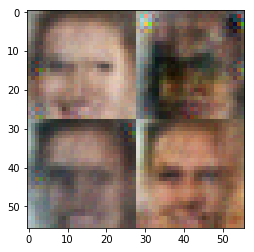

Steps 1525 Discriminator Loss: 0.8245 Generator Loss: 7.7552
Steps 1530 Discriminator Loss: 3.5074 Generator Loss: 7.5458
Steps 1535 Discriminator Loss: 0.4811 Generator Loss: 1.5383
Steps 1540 Discriminator Loss: 0.0768 Generator Loss: 3.8076


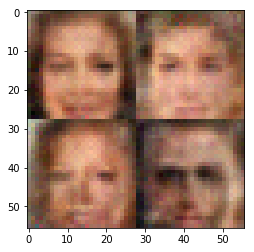

Steps 1545 Discriminator Loss: 0.7060 Generator Loss: 2.9765
Steps 1550 Discriminator Loss: 0.0222 Generator Loss: 7.0902
Steps 1555 Discriminator Loss: 0.1117 Generator Loss: 4.8089
Steps 1560 Discriminator Loss: 0.0776 Generator Loss: 7.8000


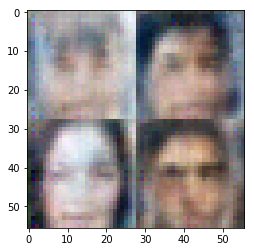

Steps 1565 Discriminator Loss: 0.1179 Generator Loss: 4.8843
Steps 1570 Discriminator Loss: 1.8501 Generator Loss: 7.1161
Steps 1575 Discriminator Loss: 0.9054 Generator Loss: 0.7617
Steps 1580 Discriminator Loss: 0.1997 Generator Loss: 2.2075


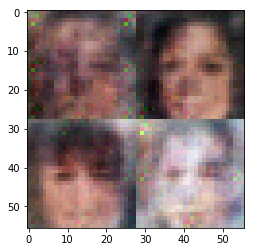

Finished Training. The result: 


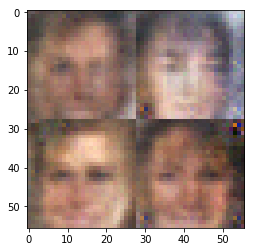

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.